In [ ]:
%matplotlib inline

# Document similarity methods

In this notebook, we illustrate different document similarity methods and use them to retrieve similar customer reviews. The method word movers' distance is illustrated. This method depends on word embeddings too, but also look at an 'individual words' viewpoint.

## Word movers' distance

WMD uses normalised word embeddings and Bag of words to calculate distance between sentences/ documents. It resolves the problem of synonyms between sentences. The intution behind the method is that we find the minimum "traveling distance" between documents, in other words the most efficient way to "move" the distribution of sentence/document 1 to the distribution of sentence/ document 2.

A good illustration is the two sentences below:
sentence_obama and sentence_president

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


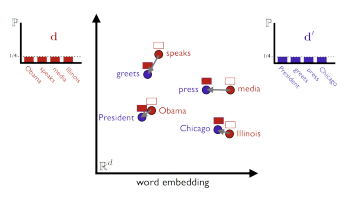

In [ ]:
# Image from https://vene.ro/images/wmd-obama.png
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time

from PIL import Image
import requests
from io import BytesIO
response = requests.get('https://vene.ro/images/wmd-obama.png')
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/4/')

In [ ]:
# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'

## Preprocessing
First, let's do some pre-processing, removing stopwords and punctuation. 

In [ ]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

# Pre-processing a document.
from nltk import word_tokenize
download('punkt')  # Download data for tokenizer.

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

sentence_obama = preprocess(sentence_obama)
print(sentence_obama)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['obama', 'speaks', 'media', 'illinois']


We will use the word vectors that are pre-trained and available from google. https://code.google.com/archive/p/word2vec/ They are hosted in gensim. These are from part of Google News dataset (about 100 billion words) with 300-dimensional vectors for 3 million words and phrases.

More options:
https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec
model = api.load('word2vec-google-news-300')

2021-09-04 07:46:57,545 : INFO : 'pattern' package not found; tag filters are not available for English
2021-09-04 07:46:57,627 : INFO : Creating /root/gensim-data


[==================================================] 100.0% 1662.8/1662.8MB downloaded


2021-09-04 07:54:59,654 : INFO : word2vec-google-news-300 downloaded
2021-09-04 07:54:59,674 : INFO : loading projection weights from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2021-09-04 08:02:58,481 : INFO : loaded (3000000, 300) matrix from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


The WMD model is based on the word vectors, and can be obtained directly from the distance measure from the individual word vectors. Note the sentence on Obama and the president has a distance of 3.79. 
Note that similarity and distance are opposites. When the distance is high, the similarity is low. Vice versa is true as well.

In [ ]:
distance = model.wmdistance(sentence_obama, sentence_president)
print('distance = %.4f' % distance)

2021-09-04 08:03:28,513 : INFO : Removed 0 and 7 OOV words from document 1 and 2 (respectively).
2021-09-04 08:03:28,515 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:03:28,517 : INFO : built Dictionary(18 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'C']...) from 2 documents (total 38 corpus positions)


distance = 3.7959


Notice that in another case with a very different sentence talking about oranges, the distance is bigger (less similar) at 4.4

In [ ]:
sentence_orange = preprocess('Oranges are my favorite fruit')
distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

2021-09-04 08:03:47,957 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:03:47,962 : INFO : built Dictionary(7 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'favorite']...) from 2 documents (total 7 corpus positions)


distance = 4.3802


In [ ]:
sentence_apple = preprocess('Apple are my favorite fruit')
sentence_Apple = preprocess('Apple is a huge company')
distance = model.wmdistance(sentence_apple, sentence_orange)
print('distance = %.4f' % distance)

2021-09-04 08:04:53,113 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:04:53,117 : INFO : built Dictionary(4 unique tokens: ['apple', 'favorite', 'fruit', 'oranges']) from 2 documents (total 6 corpus positions)


distance = 1.0462


In [ ]:
distance = model.wmdistance(sentence_Apple, sentence_orange)
print('distance = %.4f' % distance)

2021-09-04 08:05:19,247 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:05:19,256 : INFO : built Dictionary(6 unique tokens: ['apple', 'company', 'huge', 'favorite', 'fruit']...) from 2 documents (total 6 corpus positions)


distance = 3.3290


## Normalising WMD
 
In the WMD distance, sentences of different lenghts can increase the distance. This is due to different word vectors lengths of the sentences. To mitigate this, the document vectors of the sentences are each normalised to the same dimension. The normalisation in this case reduces the distance lengths.

In [ ]:
model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.

distance = model.wmdistance(sentence_obama, sentence_president)  # Compute WMD as normal.
print('distance: %r' % distance)

distance = model.wmdistance(sentence_obama, sentence_orange)
print('distance = %.4f' % distance)

2021-09-04 08:06:39,657 : INFO : precomputing L2-norms of word weight vectors
2021-09-04 08:07:10,634 : INFO : Removed 0 and 7 OOV words from document 1 and 2 (respectively).
2021-09-04 08:07:10,638 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:07:10,641 : INFO : built Dictionary(18 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'C']...) from 2 documents (total 38 corpus positions)
2021-09-04 08:07:10,648 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:07:10,651 : INFO : built Dictionary(7 unique tokens: ['illinois', 'media', 'obama', 'speaks', 'favorite']...) from 2 documents (total 7 corpus positions)


distance: 1.2396976888651379
distance = 1.3663


## Building our own word vectors

Instead of using the word vectors from Google, we train our own word vectors in this yelp reviews case. This is in json format and in particular we look at 6 restaurant IDs. This reviews dataset is available from Kaggle. https://www.kaggle.com/yelp-dataset/yelp-dataset 
The following code reads in the reviews one by one into the wmd_corpus (only for the 6 restaurant IDs) and the w2v corpus (for training word vectors.)

As always, training a new word vector model is advantageous since this trained model will reflect the semantics of this reviews case. 

In [ ]:
start = time()

import json

# Review IDs of the restaurants.
ids = ['fWKvX83p0-ka4JS3dc6E5A', 'IjZ33sJrzXqU-0X6U8NwyA', 'IESLBzqUCLdSzSqm0eCSxQ',
      '1uJFq2r5QfJG_6ExMRCaGw', 'm2CKSsepBCoRYWxiRUsxAg', 'jJAIXA46pU1swYyRCdfXtQ']

w2v_corpus = []  # Documents to train word2vec on (all 6 restaurants).
wmd_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
with open('yelp_academic_dataset_review.json') as data_file: 
    for line in data_file:
        json_line = json.loads(line)
        if json_line['review_id'] not in ids:
            # Not one of the 6 restaurants.
            continue
         
        # Pre-process document.
        text = json_line['text']  # Extract text from JSON object.
        text = preprocess(text)
        # Add to corpus for training Word2Vec.
        w2v_corpus.append(text)

        if json_line['review_id'] in ids:
            # Add to corpus for similarity queries.
            wmd_corpus.append(text)
            documents.append(json_line['text'])

Train a new word vector model for the WMD similarity and then use it for the Word similarity model (WMD). 

In [ ]:
# w2v_corpus   # simply a 2D list of tokens, for training the w2v
# wmd_corpus   # simply a 2D list of tokens, search space
# documents   # list of raw document

['My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!',
 'I have no idea why some people give bad reviews about this place. It goes to show you, you can

In [ ]:
# Train Word2Vec on all the restaurants. 
n_model = Word2Vec(w2v_corpus, workers=3, size=100, min_count=1)

# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
num_best = 5
instance = WmdSimilarity(wmd_corpus, n_model, num_best=5)  # means the top 5 documents are retrieved

# wmd_corpus -- search space
# n_model - the w2v model

# possible sentences come from only the wmd_corpus.
# WMD based on the word2vec from w2c corpus.
# you must first build vocabulary before training the model --> usually due to empty w2v_corpus

2021-09-04 09:53:34,063 : INFO : collecting all words and their counts
2021-09-04 09:53:34,065 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-04 09:53:34,071 : INFO : collected 318 word types from a corpus of 438 raw words and 6 sentences
2021-09-04 09:53:34,075 : INFO : Loading a fresh vocabulary
2021-09-04 09:53:34,078 : INFO : effective_min_count=1 retains 318 unique words (100% of original 318, drops 0)
2021-09-04 09:53:34,081 : INFO : effective_min_count=1 leaves 438 word corpus (100% of original 438, drops 0)
2021-09-04 09:53:34,085 : INFO : deleting the raw counts dictionary of 318 items
2021-09-04 09:53:34,087 : INFO : sample=0.001 downsamples 73 most-common words
2021-09-04 09:53:34,089 : INFO : downsampling leaves estimated 354 word corpus (80.9% of prior 438)
2021-09-04 09:53:34,092 : INFO : estimated required memory for 318 words and 100 dimensions: 413400 bytes
2021-09-04 09:53:34,095 : INFO : resetting layer weights
2021-09-04 09:53:34,

Test it on one of the review sentences. 

In [ ]:
start = time()
sent = 'love the gyro plate. Rice is so good and I also dig their candy selection.'
query = preprocess(sent)
sims = instance[query]  # A query is simply a "look-up" in the similarity class.
print ('Cell took %.2f seconds to run.' %(time() - start))

2021-09-04 08:18:48,922 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:18:48,924 : INFO : built Dictionary(76 unique tokens: ['absolute', 'absolutely', 'amazing', 'anyway', 'arrived']...) from 2 documents (total 85 corpus positions)
2021-09-04 08:18:48,955 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:18:48,956 : INFO : built Dictionary(90 unique tokens: ['arrived', 'awesome', 'back', 'bad', 'baked']...) from 2 documents (total 120 corpus positions)
2021-09-04 08:18:48,989 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:18:48,990 : INFO : built Dictionary(9 unique tokens: ['also', 'candy', 'dig', 'good', 'gyro']...) from 2 documents (total 18 corpus positions)
2021-09-04 08:18:48,995 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 08:18:48,997 : INFO : built Dictionary(44 unique tokens: ['albeit', 'always', 'assure', 'awesome', 'case']...) from 2 documents (total 47 corpu

Cell took 0.18 seconds to run.


Output the num_best sentences that are most similar to the query.

In [ ]:
# Print the query and the retrieved documents, together with their similarities.
print ('Query:', sent)
print('='*50)
for i in range(num_best):
    print (i, '----')
    print (documents[sims[i][0]])   # the document 
    print ('sim = %.4f' % sims[i][1])   # the similarity score

Query: love the gyro plate. Rice is so good and I also dig their candy selection.
0 ----
love the gyro plate. Rice is so good and I also dig their candy selection :)
sim = 1.0000
1 ----
General Manager Scott Petello is a good egg!!! Not to go into detail, but let me assure you if you have any issues (albeit rare) speak with Scott and treat the guy with some respect as you state your case and I'd be surprised if you don't walk out totally satisfied as I just did. Like I always say..... "Mistakes are inevitable, it's how we recover from them that is important"!!!

Thanks to Scott and his awesome staff. You've got a customer for life!! .......... :^)
sim = 0.4394
2 ----
Quiessence is, simply put, beautiful.  Full windows and earthy wooden walls give a feeling of warmth inside this restaurant perched in the middle of a farm.  The restaurant seemed fairly full even on a Tuesday evening; we had secured reservations just a couple days before.

My friend and I had sampled sandwiches at the Far

**Workshop submission:**

Use the news.xls corpus to replace the yelp academic dataset to re-construct a word vector model. Let’s call this word vector model WV_News and the word vector model from Yelp reviews WV_Yelp. 


*   Get the most similar document for the following two sentences from two models (Yelp & WV_NEWS):


sentence_1: The pandemic is showing little sign of slowing down, with more than 10,000 new deaths recorded worldwide every day. according to an AFP tally.

Yelp doc:

WV_NEWS doc:


---


Sentence_2:The dollar's weakening is likely to last at least another six months as investors continue to shift to risky assets and higher returns from a Reuters poll.

Yelp doc:

WV_NEWs doc:



---



*   Comment on your findings. For eg. On the choice of words, the usage/ size of the corpus – all these can affect the results). Does a different word vector corpus affect also the similarity scores? Also, on the ‘extracted’ news sentence outcome. Does it look suitable?







 **preparing the copus   
Only taking 20% of the documents since it was very slow**

In [ ]:


w2v_corpus_news = []  # Documents to train word2vec on (all 6 restaurants).
wmd_corpus_news = []  # Documents to run queries against (only one restaurant).
documents_news = []  # wmd_corpus, with no pre-processing (so we can see the original documents).
import pandas as pd
news = pd.read_excel("news.xlsx")
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
docs = news['Short']


In [ ]:
docs.index = docs.index.astype(int)
docs  = docs[docs.index%5==0]  # only using 20% of the dataset
print(docs.shape)
docs.head

(11021,)


<bound method NDFrame.head of 0        The CBI on Saturday booked four former officia...
5        A new trailer for the upcoming superhero film ...
10       The Centre on Saturday dismissed reports which...
15       Indian spinner Kuldeep Yadav, who registered 4...
20       The Indian Army, after consultations with the ...
                               ...                        
55080    Bollywood actors including Shah Rukh Khan, Dee...
55085    A Facebook user has a maximum of 155 real frie...
55090    The tariff for grid-connected solar power in t...
55095    Two militants, who were reportedly holed up in...
55100    Amid growing concerns about China&#39;s econom...
Name: Short, Length: 11021, dtype: object>

In [ ]:
import random
for line in docs:
    text = preprocess(line)
    w2v_corpus_news.append(text)
    if random.randint(0, 100)<5:  # only adding 5% of the docs in to the search space
      wmd_corpus_news.append(text)
      documents_news.append(line)

In [ ]:
w2v_news = Word2Vec(w2v_corpus_news, workers=3, size=100, min_count=1)
instance_news = WmdSimilarity(wmd_corpus_news, w2v_news, num_best=5)  # means the top 5 documents are retrieved

2021-09-04 09:54:36,852 : INFO : collecting all words and their counts
2021-09-04 09:54:36,854 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-09-04 09:54:36,966 : INFO : PROGRESS: at sentence #10000, processed 339329 words, keeping 30000 word types
2021-09-04 09:54:36,979 : INFO : collected 31404 word types from a corpus of 374341 raw words and 11021 sentences
2021-09-04 09:54:36,980 : INFO : Loading a fresh vocabulary
2021-09-04 09:54:37,048 : INFO : effective_min_count=1 retains 31404 unique words (100% of original 31404, drops 0)
2021-09-04 09:54:37,051 : INFO : effective_min_count=1 leaves 374341 word corpus (100% of original 374341, drops 0)
2021-09-04 09:54:37,163 : INFO : deleting the raw counts dictionary of 31404 items
2021-09-04 09:54:37,167 : INFO : sample=0.001 downsamples 14 most-common words
2021-09-04 09:54:37,170 : INFO : downsampling leaves estimated 368266 word corpus (98.4% of prior 374341)
2021-09-04 09:54:37,269 : INFO : estimated r

In [ ]:
sent1 = 'The pandemic is showing little sign of slowing down, with more than 10,000 new deaths recorded worldwide every day. according to an AFP tally.'
query1 = preprocess(sent1)


In [ ]:

sims_news_1 = instance_news[query1]  

print ('Query:', sent1)
print('='*50)
for i in range(num_best):
    print (i, '----')
    print('News model')
    print (documents_news[sims_news_1[i][0]])   # the document 
    print ('sim = %.4f' % sims_news_1[i][1])   # the similarity score


Query: The pandemic is showing little sign of slowing down, with more than 10,000 new deaths recorded worldwide every day. according to an AFP tally.
0 ----
News model
According to the first world-wide assessment of flora, carried out by UK-based Royal Botanic Gardens, Kew, 21% of Earth&#39;s floral species are at risk of extinction. The reported causes included climate change, diseases, habitat loss and invasive species. With 2,034 new species discovered in 2015, scientists have estimated that there are around 390,900 different species of plant on the planet.
sim = 0.8626
1 ----
News model
GoPro has appointed Danny Coster, an industrial designer at Apple, as its VP of Design, effective April end. Coster, a core member of Apple since early 90s, has contributed to the iPhone 4, the iPad wireless keyboard and holds over 500 design patents. The executive switch has caused GoPro’s stock to jump to its highest level since mid-January.
sim = 0.8545
2 ----
News model
South Korean smartphone m

In [ ]:
sims_yelp_1 = instance[query1]

print ('Query:', sent1)
print('='*50)
for i in range(num_best):
    print (i, '----')
    print('Yelp model')
    if len(sims_yelp_1)>=num_best:
      print (documents[sims_yelp_1[i][0]])   # the document 
      print ('sim = %.4f' % sims_yelp_1[i][1])   # the similarity score
    else:
      print('no result')



2021-09-04 10:16:54,867 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:54,869 : INFO : At least one of the documents had no words that werein the vocabulary. Aborting (returning inf).
2021-09-04 10:16:54,872 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:54,874 : INFO : At least one of the documents had no words that werein the vocabulary. Aborting (returning inf).
2021-09-04 10:16:54,880 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:54,881 : INFO : At least one of the documents had no words that werein the vocabulary. Aborting (returning inf).
2021-09-04 10:16:54,884 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:54,886 : INFO : At least one of the documents had no words that werein the vocabulary. Aborting (returning inf).
2021-09-04 10:16:54,888 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respe

Query: The pandemic is showing little sign of slowing down, with more than 10,000 new deaths recorded worldwide every day. according to an AFP tally.
0 ----
Yelp model
no result
1 ----
Yelp model
no result
2 ----
Yelp model
no result
3 ----
Yelp model
no result
4 ----
Yelp model
no result


In [ ]:
sent2 = "The dollar's weakening is likely to last at least another six months as investors continue to shift to risky assets and higher returns"
query2 = preprocess(sent2)
sims_news_2 = instance_news[query2] 

print ('Query:', sent2)
print('='*50)
for i in range(num_best):
    print (i, '----')
    print('News model')
    print (documents_news[sims_news_2[i][0]])   # the document 
    print ('sim = %.4f' % sims_news_2[i][1])   # the similarity score

2021-09-04 10:05:53,221 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:05:53,223 : INFO : built Dictionary(46 unique tokens: ['age', 'beacon', 'bhopal', 'boy', 'causes']...) from 2 documents (total 49 corpus positions)
2021-09-04 10:05:53,252 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:05:53,253 : INFO : built Dictionary(46 unique tokens: ['according', 'bar', 'came', 'ceo', 'contacted']...) from 2 documents (total 51 corpus positions)
2021-09-04 10:05:53,273 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:05:53,274 : INFO : built Dictionary(44 unique tokens: ['added', 'additions', 'atlas', 'based', 'called']...) from 2 documents (total 50 corpus positions)
2021-09-04 10:05:53,293 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:05:53,295 : INFO : built Dictionary(48 unique tokens: ['artist', 'bae', 'bob', 'crying', 'done']...) from 2 documents (total 51 corpus positio

Query: The dollar's weakening is likely to last at least another six months as investors continue to shift to risky assets and higher returns
0 ----
News model
Tata Motors has reported a marginal 1.45% growth in sales at 40,071 units in May, compared to 39,496 in the corresponding period a year ago. Domestic sales of passenger vehicles dropped 22.6% to 8,617 units while the commercial vehicles segment witnessed a 14% rise in sales in the domestic markets to 27,026 units. Exports fell by 5.3% to 4,428 units.
sim = 0.8695
1 ----
News model
Astronomers have confirmed the discovery​ of a 5 to 10 million years old exoplanet, making it the youngest ever to be discovered. Nearly 3,000 exoplanets have been discovered so far with most of them aged more than a billion years. The discovery could provide scientists with new insights into how planets and solar systems are formed.
sim = 0.8571
2 ----
News model
In a bid to retain drivers, Chennai-based taxi-hailing service UTOO Cabs is giving its dr

In [ ]:
sims_yelp_2 = instance[query2]

print ('Query:', sent2)
print('='*50)
for i in range(num_best):
    print (i, '----')
    print('Yelp model')
    if len(sims_yelp_2)>=num_best:
      print (documents[sims_yelp_2[i][0]])   # the document 
      print ('sim = %.4f' % sims_yelp_2[i][1])   # the similarity score
    else:
      print('no result')

2021-09-04 10:16:17,755 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:17,759 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:16:17,762 : INFO : built Dictionary(68 unique tokens: ['absolute', 'absolutely', 'amazing', 'anyway', 'arrived']...) from 2 documents (total 77 corpus positions)
2021-09-04 10:16:17,782 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:17,783 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:16:17,787 : INFO : built Dictionary(83 unique tokens: ['arrived', 'awesome', 'back', 'bad', 'baked']...) from 2 documents (total 112 corpus positions)
2021-09-04 10:16:17,804 : INFO : Removed 0 and 14 OOV words from document 1 and 2 (respectively).
2021-09-04 10:16:17,805 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-09-04 10:16:17,810 : INFO : built Dictionary(10 unique tokens: ['also', 'candy', 'dig', 'good', 'gy

Query: The dollar's weakening is likely to last at least another six months as investors continue to shift to risky assets and higher returns
0 ----
Yelp model
Nobuo shows his unique talents with everything on the menu. Carefully crafted features with much to drink. Start with the pork belly buns and a stout. Then go on until you can no longer.
sim = 0.4156
1 ----
Yelp model
Quiessence is, simply put, beautiful.  Full windows and earthy wooden walls give a feeling of warmth inside this restaurant perched in the middle of a farm.  The restaurant seemed fairly full even on a Tuesday evening; we had secured reservations just a couple days before.

My friend and I had sampled sandwiches at the Farm Kitchen earlier that week, and were impressed enough to want to eat at the restaurant.  The crisp, fresh veggies didn't disappoint: we ordered the salad with orange and grapefruit slices and the crudites to start.  Both were very good; I didn't even know how much I liked raw radishes and turnips

**Workshop submission:**

Use the news.xls corpus to replace the yelp academic dataset to re-construct a word vector model. Let’s call this word vector model WV_News and the word vector model from Yelp reviews WV_Yelp. 


*   Get the most similar document for the following two sentences from two models (Yelp & WV_NEWS):


sentence_1: The pandemic is showing little sign of slowing down, with more than 10,000 new deaths recorded worldwide every day. according to an AFP tally.

Yelp doc:  *No* *Result*

WV_NEWS doc: According to the first world-wide assessment of flora, carried out by UK-based Royal Botanic Gardens, Kew, 21% of Earth&#39;s floral species are at risk of extinction. The reported causes included climate change, diseases, habitat loss and invasive species. With 2,034 new species discovered in 2015, scientists have estimated that there are around 390,900 different species of plant on the planet.
(sim = 0.8626)


---


Sentence_2:The dollar's weakening is likely to last at least another six months as investors continue to shift to risky assets and higher returns from a Reuters poll.

Yelp doc: Nobuo shows his unique talents with everything on the menu. Carefully crafted features with much to drink. Start with the pork belly buns and a stout. Then go on until you can no longer.
(sim = 0.4156)

WV_NEWs doc: Tata Motors has reported a marginal 1.45% growth in sales at 40,071 units in May, compared to 39,496 in the corresponding period a year ago. Domestic sales of passenger vehicles dropped 22.6% to 8,617 units while the commercial vehicles segment witnessed a 14% rise in sales in the domestic markets to 27,026 units. Exports fell by 5.3% to 4,428 units.
(sim = 0.8695)



---



*   Comment on your findings. For eg. On the choice of words, the usage/ size of the corpus – all these can affect the results). Does a different word vector corpus affect also the similarity scores? Also, on the ‘extracted’ news sentence outcome. Does it look suitable?

**The news model is able to produce a result which is close to the query, but the quality is not satisfying, since the search space is only a random 5% of the considered documents, (due to runtime limitations)   
For the yelp model, the performance is very bad. It cannot produce any result for the 1st query and it produced a very poor result on the second query. This is also expected because the corpus used to train the yelp model is different, the search space is also just 6 reviews from yelp, so we can expect the yelp model to be useless for queries from news dataset.**

** This further imples that the training and testing has to be on similar corpus/domain for any models to work effectively **

